# Wine quality analysis

We would like to find excellent wine (quality >= 8)

#### This notebook is very similar with 02 notebook. Please skip and go to conclusion section if you already have seen 02 before.

In this notebook, our classifier could detect excellent wine only by using oversampling technique. We use oversampling on all features, but we also could combine PCA/ preselected features with oversampling.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE


from vars import colors

from evaluate import plot_roc_pr_curves, evaluate_cls
from preprocessing import create_sets, remove_outlier
from functional import add_cls_res

# Import the data
We have run previous analysis on red wine on 01 notebook. Now, we'll run our analysis on **red** wines. 

(But..) feel free to use the full methodology:
- on red wine only
- on both wines with color as a feature.


In [2]:
# Target color
tgt_wine = 'red'
# Threshold good wine/ bad wine
th = 8

rslt_col = ['method', 'dataset', 'pr_m', 'rec_m', 'f1_m', 'pr_w', 'rec_w', 'f1_w', 'auc', 'pr']
results_df = pd.DataFrame(columns=rslt_col)

# Open files
wine_path = f'__data__/winequality-{tgt_wine}.csv'
wine_df = pd.read_csv(wine_path, delimiter=';')

# Process column name
wine_df = wine_df.rename(columns=lambda x: x.replace(' ', '_'))

display(wine_df.head())

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Overview of the data statistics

▶ There are no missing values.

▶ All features are quantitative. Some predictors seems to have outliers (maximum >> Q75). 

▶ There are 240 duplicated row. We keep them because it might me different wine tester. 


In [3]:
# Count total NaN at each column in a DataFrame 
print(" \nCount total NaN at each column in white wine DataFrame : \n\n", 
      wine_df.isnull().sum())

# Duplicata
duplicata_per = 100*wine_df.duplicated().sum()/len(wine_df)
print(f' Number of duplicated rows: {duplicata_per:.2f}')

display(wine_df[wine_df.duplicated(keep=False)].head().sort_values(by='chlorides'))

 
Count total NaN at each column in white wine DataFrame : 

 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
 Number of duplicated rows: 15.01


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
11,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
22,7.9,0.43,0.21,1.6,0.106,10.0,37.0,0.9966,3.17,0.91,9.5,5


In [4]:
# Main statistics
display(wine_df.describe().round(2))

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,1.00,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,0.00,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


# Distribution of the target
The target distribution seems normal (but we could double check it with tests such as Shapiro).

▶ Very low and high quality wines are rare.

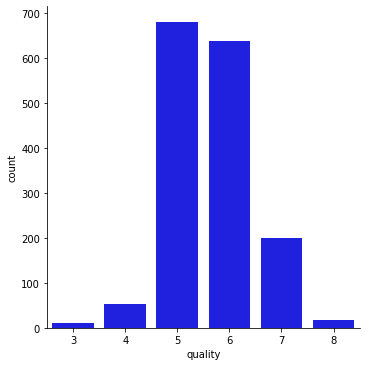

In [5]:
# Distribution of the target
sns.catplot(x='quality', data=wine_df, kind='count', color='b')

# Binarize 
We use a threshold t=8 to binarize the data.

The resulting class repartition is still unbalanced.

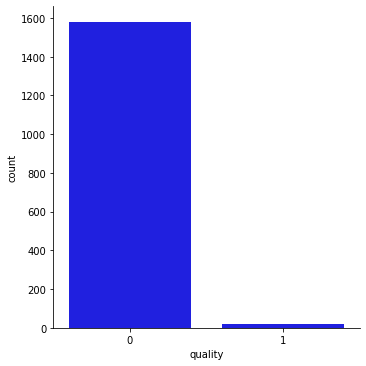

In [6]:
wine_df.quality = [1 if x >= th else 0 for x in wine_df.quality]

# Binary distribution of the target
sns.catplot(x='quality', data=wine_df, kind='count', color='b')

# Baseline
For red wines, the most frequent class (86% of the dataset) is 6.

We consider that a dummy classifier performance (predict all red wine as class 6) would have a average accuracy of 86%.

In [7]:
print(wine_df['quality'].value_counts(normalize=True, dropna=False).round(3) * 100)

0    98.9
1     1.1
Name: quality, dtype: float64


# Visualization of the correlation 

We want to visualize **pair-wise correlations** of the different features, and the **strenght of the correlation**.


We use a **scatterplot** for visualize the correlations and the **correlation matrix** (standardized covariance matrice) to quantify them.

▶ We can observe: 

- Scatterplot:
    - Linear relationship between the target (_quality_) and some parameters (_density, pH, sulfate and fixed acidity_). 
- Correlation matrix:
    - Multicollinearity between features (alchohol/ density or density/fixed acidity). 

▶  Relationships between features seem stronger with red than white wines.


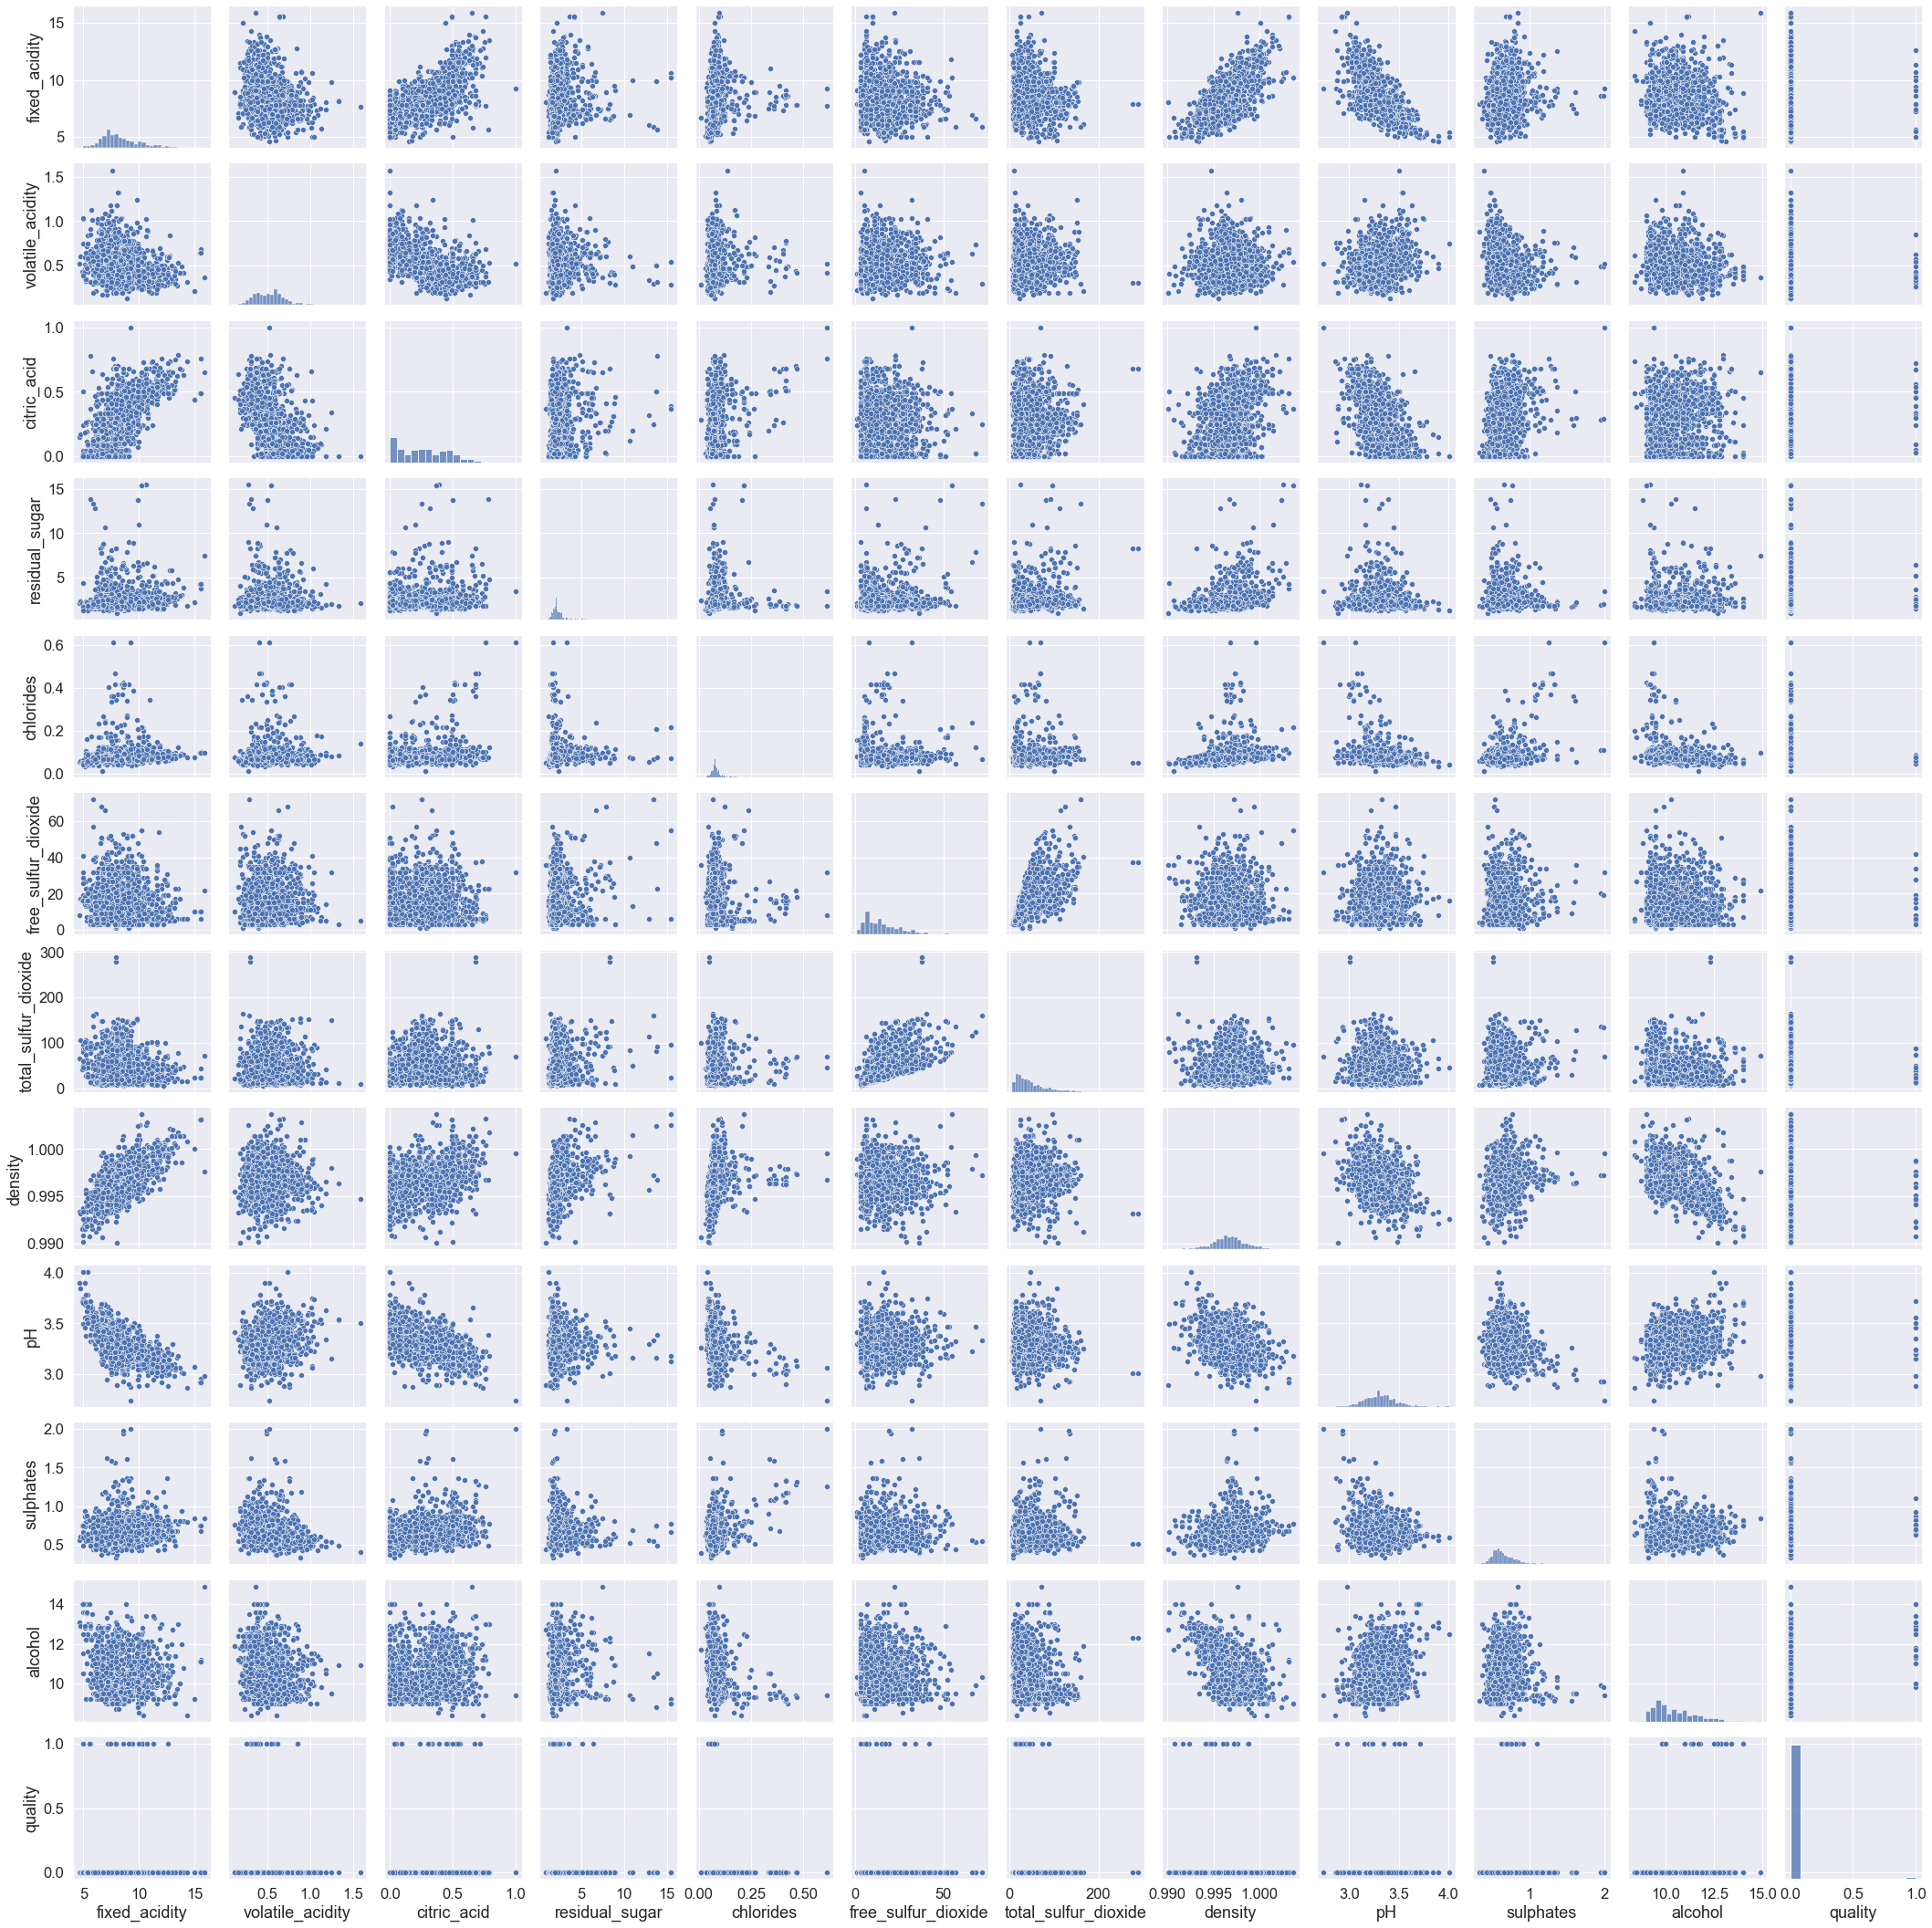

In [8]:
sns.set(font_scale=1.5) 

sns.pairplot(wine_df)
plt.show()


# Correlation


The highly correlated variable contributing the less for quality are:
- residual sugar
- fixed acidity

We remind them for later feature selection.

Text(0.5, 1.0, 'Correlation Heatmap')

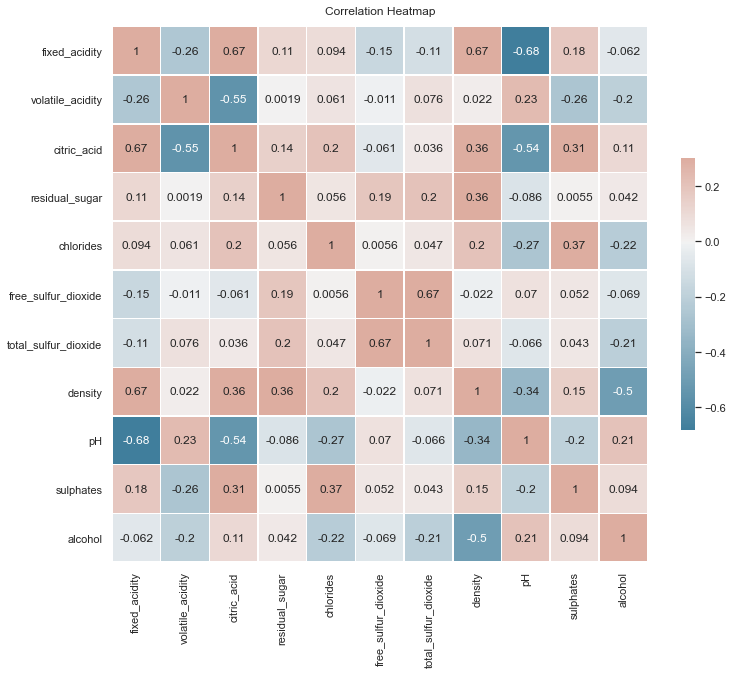

In [9]:
sns.set(font_scale=1) 

# Making the result reproducible
RANDOM_STATE = 42
tgt_col = ['quality']
# For first 
feat_col = wine_df.columns[:-1]

# 1, -1 is perfect positive, negative respectively correlation
# 0 is no correlation

# Compute correlation matrix
corr = wine_df[feat_col].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap and correct aspect ratio
heatmap = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# Distribution and outliers

## Distributions
▶ Citric acid, sulfure and alcohol are skewed distributions.

We won't perform operation to normalize the data and will skip the statistical tests.


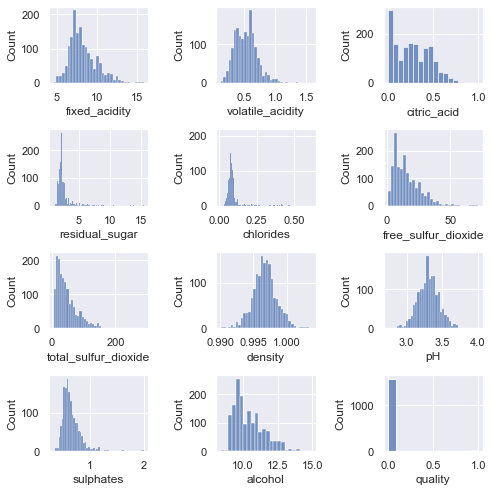

In [10]:
fig, axs = plt.subplots(4,3, figsize=(7,7))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.histplot(x=feat, ax=axs[i], data=wine_df)
plt.tight_layout()

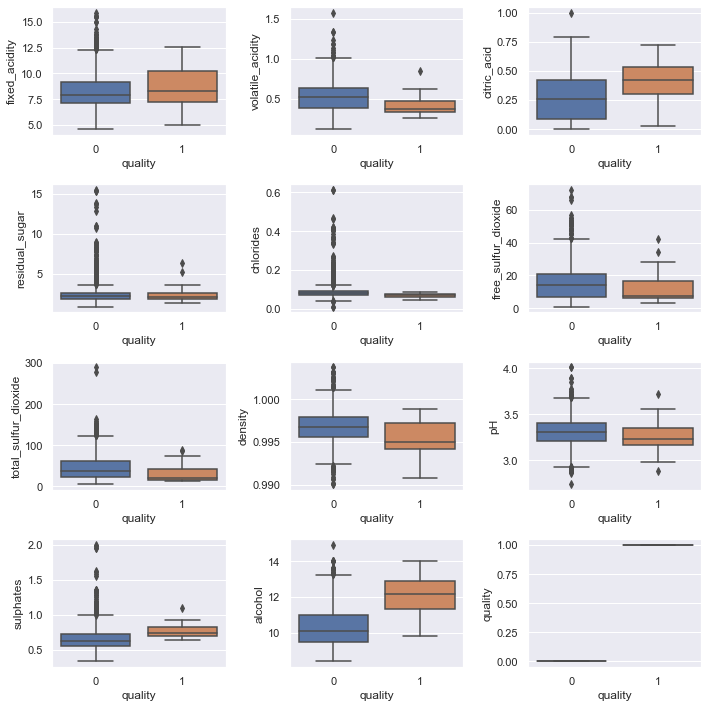

In [11]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.boxplot(y=feat, ax=axs[i], data=wine_df, x='quality')
plt.tight_layout()

# Data engineering

##### Removing outliers helps to see clearly the distribution and how a feature influence the target.


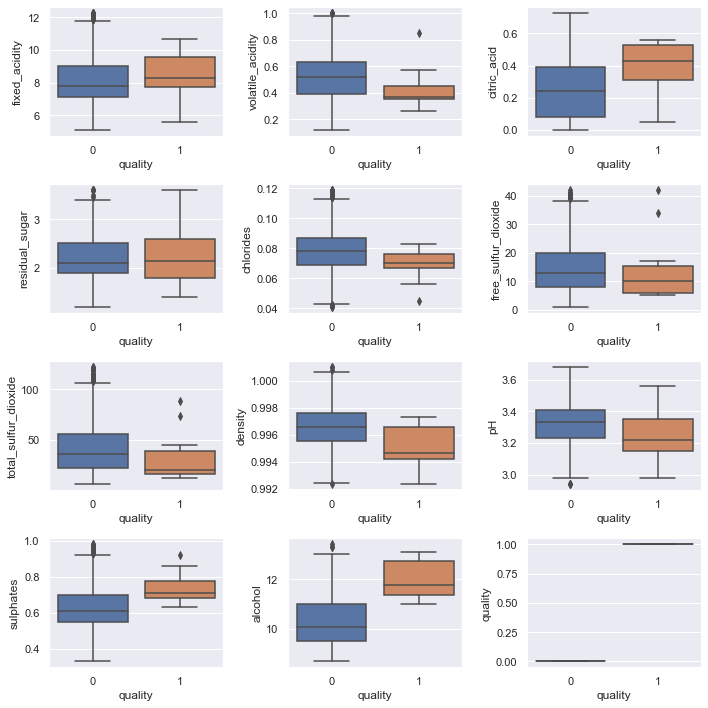

In [12]:
# We remove the outliers from our analysis
wine_df = remove_outlier(wine_df, feat_col)
fig, axs = plt.subplots(4,3, figsize=(10,10))
axs = axs.flatten()
for i, feat in enumerate(wine_df.columns):
    sns.boxplot(y=feat, ax=axs[i], data=wine_df, x='quality')
plt.tight_layout()

## Conclusion for EDA
#### Quality prediction will be challenging. Even binarized, the dataset is very imbalanced, the predictors are correlated and overlap for different quality. 


#### Because of their high correlation with other features and low correlation with quality, think about removing:
- free or total sulfure (later significance result will make us remove total sulfure)
- residual sugar.
- fixed acidity


## Preparing the datasets for prediction

#### We create train (70%), validation (12%) and test dataset (18%). 

The dataset is stratified to keep the original class distribution in all the sets. 

We standardize the features with a scaler.

## Preparing the subsets

We will compare different subsets:
- total (all features) dataset
- preselect dataset from EDA, we remove
    - *residual sugar*
    - *free sulfure*
    - *fixed acidity*
    - *pH*
- pca (7 embedded features) dataset
- SMOTE oversampled dataset
    - we keep all features but add more minority samples. 

``ML importance subset`` is created given the features importance in LR and RF. 

In [13]:
# Later analysis let us keep these feature
preselect = [ 'volatile_acidity', 'citric_acid',
       'chlorides', 'total_sulfur_dioxide', 'density',
       'sulphates', 'alcohol']

# Creation of train, val, test set from all feature dataset.
X_train_sc, X_val_sc, X_test_sc, y_train, y_val, y_test, scaler = create_sets(wine_df, feat_col, tgt_col)
X_train_sc_pre, X_val_sc_pre, X_test_sc_pre, y_train, y_val, y_test, scaler = create_sets(wine_df, preselect, tgt_col)

Train shape: (861, 11), validation shape: (153, 11), test shape: (180, 11)
Train shape: (861, 7), validation shape: (153, 7), test shape: (180, 7)


## PCA


### We look for the number of components enough to explain 90% of the variance.

The elbow shape is unclear, but **six components** seems enough.

We could try LDA as well. 


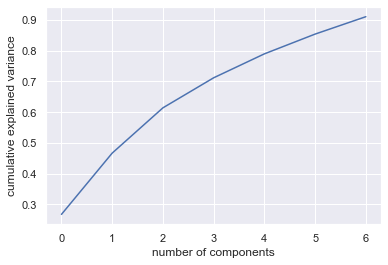

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9) 
results = pca.fit(X_train_sc) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
X_train_pca = pca.transform(X_train_sc)
X_val_pca = pca.transform(X_val_sc)
X_test_pca = pca.transform(X_test_sc)

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


# Oversampling

We excessively oversample the minority class (1% to 50%).

In [15]:
# We oversample with smote algorithm
oversample = SMOTE(k_neighbors=5)
X_train_os, y_train_os = oversample.fit_resample(X_train_sc, y_train)

for i in np.unique(y_train):
    per_os = 100 * np.sum(np.array([y_train_os==i]).astype(np.int32))/ len(y_train_os)
    per = 100 * np.sum(np.array([y_train==i]).astype(np.int32))/ len(y_train)
    print(f'Class {i}, {per:.2f}% -> {per_os:.2f}')

    


Class 0, 99.07% -> 50.00
Class 1, 0.93% -> 50.00


# I. Linear regression

We can use linear regression because the binary variable has a continuous meaning (0 < 1). 

### Takeaways:

▶ R^2 is disastrous.

▶ We cannot detect the excellent wine without oversampling. And even though, the precision is disastrous.

In [16]:
# LR and check the statistical significance (since our tgt distribution is normal)
# Create linear regression object

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_sc, y_train)
train_pred = np.rint(regr.predict(X_train_sc))
# Make predictions using the testing set
test_pred = np.rint(regr.predict(X_test_sc))

print(f'R^2 score is {regr.score(X_train_sc, y_train):.2f}')

print('Classification result on training:')
print(classification_report(y_train, train_pred))
print('Classification result on test:')
print(classification_report(y_test, test_pred))



R^2 score is 0.04
Classification result on training:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       853
           1       0.00      0.00      0.00         8

    accuracy                           0.99       861
   macro avg       0.50      0.50      0.50       861
weighted avg       0.98      0.99      0.99       861

Classification result on test:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       0.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.49      0.50      0.50       180
weighted avg       0.98      0.99      0.98       180



/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Storing results

In [17]:
# Append results for linear regression fit on each dataset 
res_list = add_cls_res('linreg', regr, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Linear regression done')

--> All
Training acc: 0.04
Test acc: 0.02
Roc AUC score 0.83
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
Training acc: 0.66
Test acc: -13.82
Roc AUC score 0.83
AUC non available
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       178
           1       0.02      0.50      0.04         2

    accuracy                           0.76       180
   macro avg       0.51      0.63      0.45       180
weighted avg       0.98      0.76      0.85       180

--> Preselected
Training acc: 0.04
Test acc: 0.02
Roc AUC score 0.91
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00    

# II. Multiclass classification

We will try and compare several model on test dataset. 

## 1. Logistic Regression


Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.75
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

Cross validation score with roc_auc 0.99
--Confusion Matrix--
--> All
Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.75
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
Training acc: 0.95
Test acc: 0.88
Roc AUC score 0.69
Precision-Recall AUC score 0.53
      

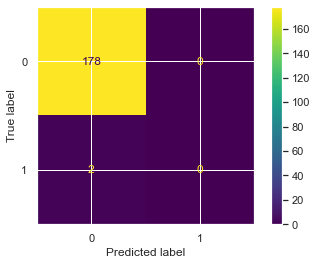

In [19]:
lr = LogisticRegression(penalty='l1', C=10.**1, solver='liblinear', random_state=RANDOM_STATE)
lr.fit(X_train_sc, y_train)

evaluate_cls(lr, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')

# Append results for linear regression fit on each dataset 
res_list = add_cls_res('lr', lr, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Logistic regression done')

## 2. Random Forest

Random forest could not detect the 

Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.55
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

Cross validation score with roc_auc 0.99
--Confusion Matrix--


[0.9944444444444445,
 0.5,
 0.49720670391061456,
 0.9890123456790124,
 0.9888888888888889,
 0.9833643699565489,
 0.5,
 0.549856118470828]

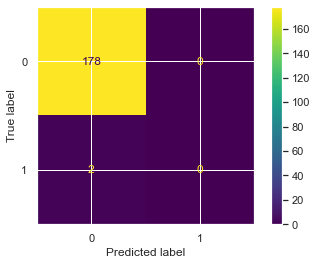

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Feature importance given the average impurity decrease in the 500 decision trees. 
forest = RandomForestClassifier(n_estimators=300,
                                random_state=RANDOM_STATE)
forest.fit(X_train_sc, y_train)
evaluate_cls(forest, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')


In [21]:
# Append results for random forest fit on each dataset 
res_list = add_cls_res('rf', forest, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('Random forest done')

--> All
Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.55
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.51
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Preselected
Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.54
              precision    recall  f1-score   suppor

### ROC and PR curves

Since RF is the highest score classifier, we take the time to look at its predictability power.

#### Precision Recall
Precision-Recall curve are more appropriate than ROC curve when the classes are imbalanced.
With PR curve, we can observe the decrease of performances to detect class the good wines.

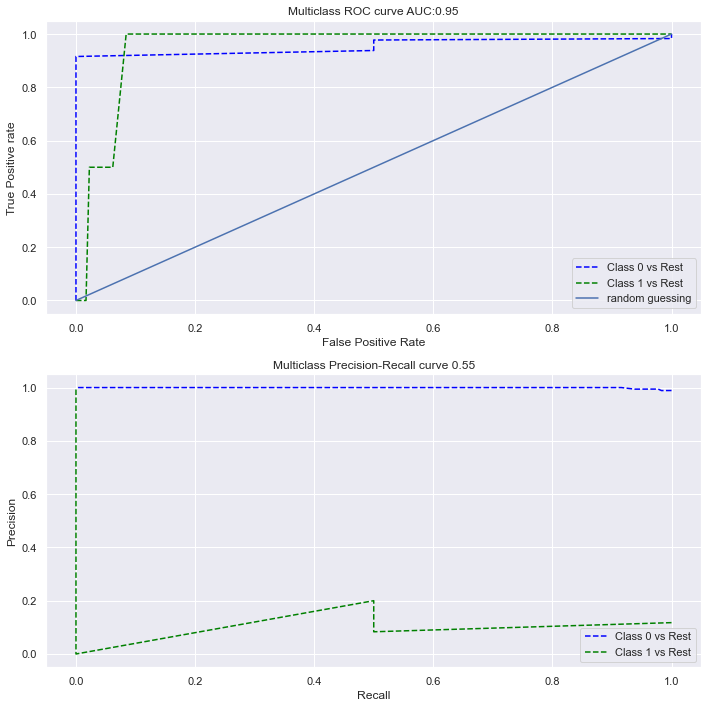

In [22]:
forest.fit(X_train_sc, y_train)
plot_roc_pr_curves(forest, X_test_sc, y_test)

## 3. SVM

Support Vector Machine are effective in high dimension space.

Results are disappointing for linear SVC, the results only detect two classes.

In [23]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, make_scorer

# # We could try 'rbf' and 'poly' kernel but the CV would not end on my local computer.
labels = np.unique(wine_df[tgt_col].values)
# parameters = {
#     'kernel': ['linear'],
#     'C': [0.001, 0.01, 0.1, 1, 2, 5, 10],
#     'gamma': [0.01, 0.1, 0.5, 1]
# }
# grid_parameters = list(ParameterGrid(parameters))
# print('Start GridSearch among', len(grid_parameters), 'possibilities')
# svc = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=0, scoring=make_scorer(f1_score, average='weighted'))
# print('param', svc.best_params_)

best_params = {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
svc = SVC(**best_params)
svc.fit(X_train_sc, y_train)

# Normal dataset
evaluate_cls(svc, X_train_sc, y_train, X_test_sc, y_test, verbose='minimal')

Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180



[0.9944444444444445,
 0.5,
 0.49720670391061456,
 0.9890123456790124,
 0.9888888888888889,
 0.9833643699565489,
 None,
 None]

### Storing results

In [24]:
# Append results for SVM fit on each dataset 
res_list = add_cls_res('svm', svc, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('SVM done')

--> All
Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
Training acc: 0.95
Test acc: 0.89
Roc AUC score 0.70
AUC non available
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       178
           1       0.05      0.50      0.09         2

    accuracy                           0.89       180
   macro avg       0.52      0.70      0.52       180
weighted avg       0.98      0.89      0.93       180

--> Preselected
Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      

## 4. MLP

We find the best hyperparameters (out of this notebook):

Like Random Forest the model overfits but test accuracy is good. 

Performances are slighlty less than Random Forest. 

### Hyperparameter search

(actually done offline)

In [25]:
# from sklearn.neural_network import MLPClassifier

# grid_parameters = {
#         'hidden_layer_sizes': [(50,50), (100,50), (500,15), (100,)],
#         'activation': ['tanh', 'relu'],
#         'solver': ['sgd', 'adam'],
#         'alpha': 10.0 ** -np.arange(1, 10),
#         'learning_rate': ['adaptive'],
#         'max_iter': [5000]
#         }
# clf = GridSearchCV(MLPClassifier(random_state=RANDOM_STATE), grid_parameters, n_jobs=-1, verbose=1)
# clf.fit(X_train_sc, y_train)


### Fitting the model with best parameters

Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.49
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

Cross validation score with roc_auc 0.99
--Confusion Matrix--


[0.9944444444444445,
 0.5,
 0.49720670391061456,
 0.9890123456790124,
 0.9888888888888889,
 0.9833643699565489,
 0.5,
 0.49451964441514945]

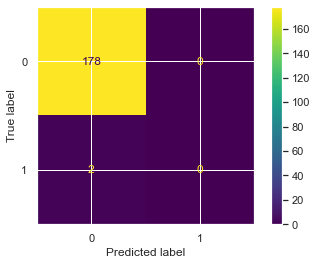

In [28]:
import joblib 

# We import the results
# cv_res = joblib.load('../output/mlp_red_cv.pkl')
# print(cv_res.best_params_)

best_params = {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (500, 15), 'learning_rate': 'adaptive', 'max_iter': 5000, 'solver': 'sgd'}
clf = MLPClassifier(random_state=RANDOM_STATE, **best_params)

clf.fit(X_train_sc, y_train)
evaluate_cls(clf, X_train_sc, y_train, X_test_sc, y_test, verbose='maximal')

### Storing results

In [29]:
# Append results for MLP fit on each dataset 
res_list = add_cls_res('mlp', svc, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)

results_df = results_df.append(res_list)
print('MLP done')

--> All
Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
Training acc: 0.95
Test acc: 0.89
Roc AUC score 0.70
AUC non available
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       178
           1       0.05      0.50      0.09         2

    accuracy                           0.89       180
   macro avg       0.52      0.70      0.52       180
weighted avg       0.98      0.89      0.93       180

--> Preselected
Training acc: 0.99
Test acc: 0.99
Roc AUC score 0.50
AUC non available
              precision    recall  f1-score   support

           0       0.99      1.00      

## 5. XGBoost

Performances similar with RF. 

In [31]:
import xgboost as xgb

xgb_ = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_.fit(X_train_sc, y_train)
val_pred = xgb_.predict(X_val_sc)
evaluate_cls(xgb_, X_train_sc, y_train, X_test_sc, y_test, verbose='minimal')



/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.52
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180



[0.9944444444444445,
 0.5,
 0.49720670391061456,
 0.9890123456790124,
 0.9888888888888889,
 0.9833643699565489,
 0.5,
 0.5175034152831449]

### Features importance
Due to the high performances of XGBoost (very slighly under RF), we check at the most important features.

<AxesSubplot:>

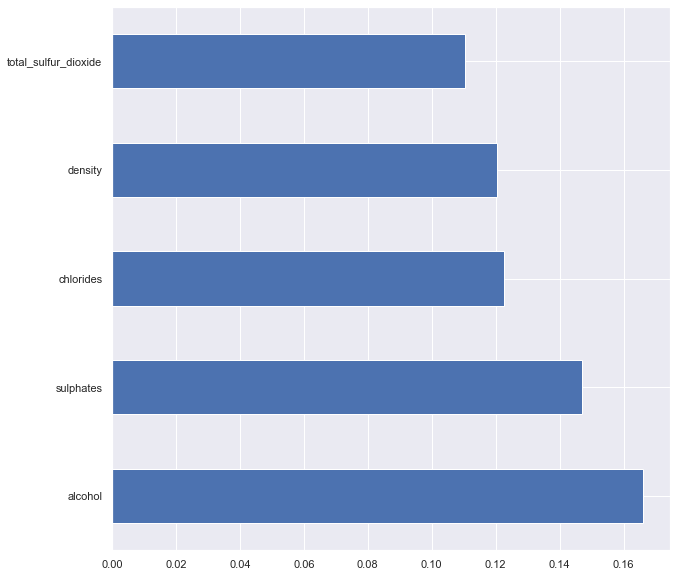

In [32]:
feat_importances = pd.Series(xgb_.feature_importances_, index=feat_col)
feat_importances.nlargest(5).plot(kind='barh',figsize=(10,10))

### Storing results

In [33]:
# Append results for XGBoost fit on each dataset 
res_list = add_cls_res('xgboost', xgb_, X_train_sc, y_train, X_test_sc, y_test,
                X_train_os, y_train_os, X_train_sc_pre, 
                X_test_sc_pre, X_train_pca, X_test_pca)
results_df = results_df.append(res_list)
print('XGBoost done')

--> All
[11:15:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.52
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Oversample
[11:15:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.51
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> Preselected
[11:15:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.51
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

--> PCA
[11:15:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/bettyld/opt/anaconda3/envs/netsmile/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training acc: 1.00
Test acc: 0.99
Roc AUC score 0.50
Precision-Recall AUC score 0.53
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       178
           1       1.00      0.00      0.00         2

    accuracy                           0.99       180
   macro avg       0.99      0.50      0.50       180
weighted avg       0.99      0.99      0.98       180

XGBoost done


# Conclusion

 The imbalance of dataset (excellent wine are only 1% of the red wine dataset) is very challenging for the classifier. With same classifiers and parameters than in 02 notebook, this time RandomForest could not detect the excellent wines.
 
Only MLP and SVM with oversampling strategy could have a non-null recall. In this configuration, they overtake XGboost and Random Forest and become the best classifiers.

### A) Best binary classifiers:

|  Model |  Dataset | F1-macro % |  F1-weighted % | Precision-m % | Recall-m % |
|---|---|---|---|---|---|
| **SVM** | oversample| 51.5  | 93.3  | 52.2  | 69.2  |
| **MLP** | oversample| 51.5  | 93.3  | 52.2  | 69.2  |

**Random forest has the highest results.**

### B) Best datasets:

``Oversampling`` was actually the only way to detect excellent wines. **We could try to oversample preselected features and PCA in a later analysis.**


In [34]:
# Overview of the results
results_df.sort_values(by=['f1_m', 'f1_w', 'pr'], ascending=False)

,method,dataset,pr_m,rec_m,f1_m,pr_w,rec_w,f1_w,auc,pr
1,svm,os,0.521875,0.696629,0.515869,0.983264,0.888889,0.931385,None,None
1,mlp,os,0.521875,0.696629,0.515869,0.983264,0.888889,0.931385,None,None
1,lr,os,0.519563,0.691011,0.508929,0.983135,0.877778,0.925066,0.691011,0.525618
0,lr,all,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.750539
0,rf,all,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.549856
2,lr,pre,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.539262
2,rf,pre,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.538482
3,xgboost,pca,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.531002
3,lr,pca,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.527258
0,xgboost,all,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364,0.5,0.517503


Text(0.5, 1.0, 'Models/Datasets by F1 macro score')

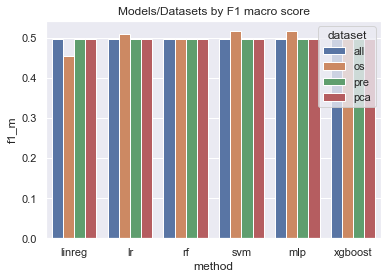

In [35]:
sns.barplot(x='method', y='f1_m', data=results_df, hue='dataset')
plt.title('Models/Datasets by F1 macro score')

Text(0.5, 1.0, 'Models/Datasets by F1 weighted score')

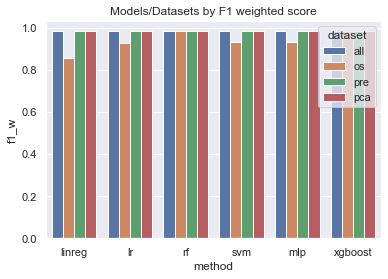

In [36]:
sns.barplot(x='method', y='f1_w', data=results_df, hue='dataset')
plt.title('Models/Datasets by F1 weighted score')

In [37]:
# Average result of each dataset on each metric
results_df.groupby('dataset').mean()

,pr_m,rec_m,f1_m,pr_w,rec_w,f1_w
dataset,,,,,,
all,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364
os,0.676697,0.619382,0.498175,0.984936,0.899074,0.934826
pca,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364
pre,0.994444,0.500000,0.497207,0.989012,0.988889,0.983364
